In [64]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
import math
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
import pandas as pd
import scipy

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import little_mallet_wrapper as lmw

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br>

# Load data

In [4]:
decameron_path = '../data/csv/decameron.csv'


In [5]:
decameron_df = pd.read_csv(decameron_path)

In [6]:
len(decameron_df.index)

100

In [7]:
decameron_df.sample(3)

,ID,Day,Story,Narrator,Gender,Text
19,2-10,2,10,filomena,woman,Ciascuno della onesta brigata sommamente comme...
91,10-2,10,2,elissa,woman,Lodata era già stata la magnificenzia del re A...
23,3-4,3,4,panfilo,man,"Poi che Filomena, finita la sua novella, si ta..."


<br><br>

# Try topic modeling

In [43]:
stopwords = ['è', 'che', 'la', 'l', 'e', 'di', 'le', 'per', 'da', 'il', 'della', 'come', 'questo', 'questa', 'quali', 'quale', 'questi']

In [44]:
training_texts = []
original_texts = []
training_narrators = []
training_genders = []

for i, r in decameron_df.iterrows():
    _chunks = [' '.join(r['Text'].split()[i:i+200]) for i in range(0, len(r['Text'].split()), 200)]
    _processed_chunks = [lmw.process_string(c, stop_words=stopwords, remove_short_words=False).strip() for c in _chunks]
    _processed_chunks = [c for c in _processed_chunks if len(c.split()) >= 20]

    for i, c in enumerate(_processed_chunks):
        training_texts.append(c)
        original_texts.append(_chunks[i])
        training_narrators.append(r['Narrator'])
        training_genders.append(r['Gender'])

len(training_texts), len(training_narrators), len(training_genders)

(1210, 1210, 1210)

In [45]:
num_topics = 20  
output_directory_path = 'output' 
path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'


In [46]:
topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_texts)

Importing data...
Complete
Training topic model...
Complete


In [47]:
assert(len(topic_distributions) == len(training_texts))

In [48]:
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 donna lei ella con sua suo giovane amore moglie padre
1 	 pietro abate ferondo monaco giovane monaci moglie ronzino buono amerigo
2 	 frate santo san rinaldo puccio alberto corpo penna gabriello marchese
3 	 calandrino bruno buffalmacco maestro noi medico angiulieri porco filippo melisso
4 	 sopra mare nave cimone duca quivi prenze gerbino vento cipri
5 	 loro lor tutti due uomini essi erano insieme furono casa
6 	 altre delle denari badessa masetto tutte lavorare lor mercatante quantità
7 	 donna camera lei ella casa letto andò vide dentro nella
8 	 tua mio mia amore tuo occhi guiscardo lagrime via tanta
9 	 morto tedaldo ciappelletto ser stato arca fante medico ruggieri corpo
10 	 voi vostra vostro avete quello mio siete mia marito madonna
11 	 donne una novella reina già assai chiamato qual molto dire
12 	 messer abate torello conte saladino mangiare alessandro rispose famigliare ghino
13 	 gisippo tito sofronia roma diavolo rustico amico giudeo giannotto ninferno
14 	 scolare n

In [49]:
for _topic in range(0, num_topics):
    print('---------------------------------------------------------------------------')
    print('TOPIC ' + str(_topic) + ': ' + ' '.join(topic_keys[_topic][:5]))
    print('---------------------------------------------------------------------------')
    print()
    for p, d in lmw.get_top_docs(original_texts, topic_distributions, topic_index=_topic, n=3):
        print(round(p, 4), d)
        print()

---------------------------------------------------------------------------
TOPIC 0: donna lei ella con sua
---------------------------------------------------------------------------

0.4824 ché io ti giuro per quello Iddio che forse già di lei innamorar mi fece acciò che il mio amore fosse, sì come stato è, cagion della sua salute, che ella mai o col padre o colla madre o con teco più onestamente non visse, che ella appresso di mia madre ha fatto nella mia casa.” E questo detto, si rivolse alla donna e disse: “Madonna, omai da ogni promessa fattami io v'assolvo e libera vi lascio di Niccoluccio”; e rimessa la donna e 'l fanciul nelle braccia di Niccoluccio si tornò a sedere. Niccoluccio disiderosamente ricevette la sua donna e 'l figliuolo, tanto più lieto quanto più n'era di speranza lontano, e come meglio poté e seppe ringraziò il cavaliere; e gli altri, che tutti di compassion lagrimavano, di questo il commendaron molto, e commendato fu da chiunque l'udì. La donna con maravigliosa

In [54]:
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap='Blues')    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

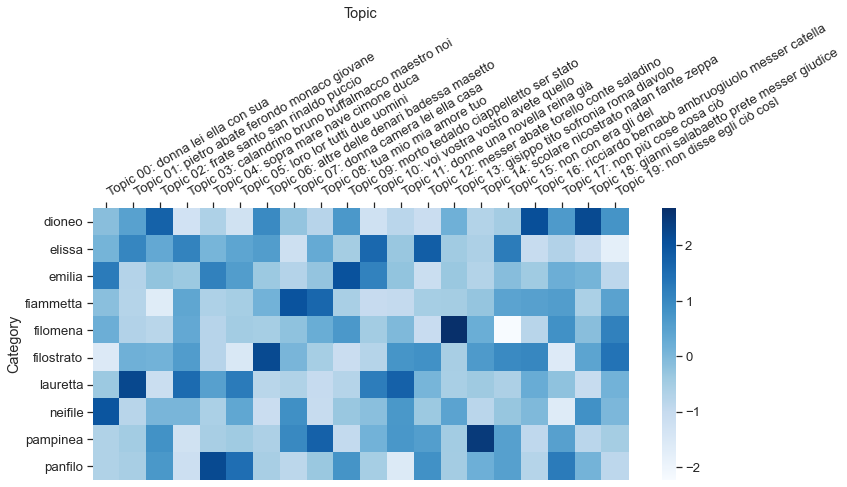

In [55]:
plot_categories_by_topics_heatmap(training_narrators,
                                  topic_distributions,
                                  topic_keys, 
                                  output_directory_path + '/narrators_by_topics.pdf',
                                  dim=(12,7))

/Users/maria/opt/anaconda3/envs/python3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


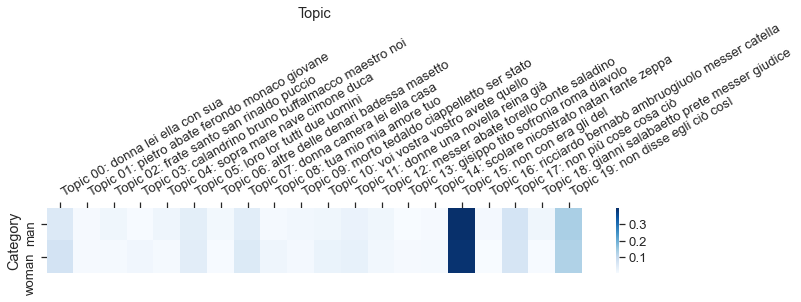

In [59]:
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    # df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_wide, cmap='Blues')    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()
    
plot_categories_by_topics_heatmap(training_genders,
                                  topic_distributions,
                                  topic_keys, 
                                  output_directory_path + '/narrators_by_topics.pdf',
                                  dim=(12,1.2))

<br><br>

# Try logistic regression

In [60]:
# first, we want to split into train and test datasets
# for training, we want to make sure that we have chunked into
# small pieces of text. We are going to divide the text into 100-word
# pieces (and not worry about leftover for simplicity)
# we also want to make sure that the train chunks come from stories
# that do not overlap with the test stories

# so to start, we will sample 80% (80) of the stories for train,
# 20% for test, and then we will chunk them

# num_train is the number of stories that will be used for training; 
# 10 - num_train is number used for test, per storyteller
def storyteller_train_test_split(storyteller, num_train=8):
	# get story ids for the story teller
	storyteller_ids =  decameron_df[decameron_df['Narrator']==storyteller]['ID'].tolist()
	train_set_story_ids = random.sample(storyteller_ids, 8)
	test_set_story_ids = [x for x in storyteller_ids if x not in train_set_story_ids]
	return train_set_story_ids, test_set_story_ids

# 30 stories by men, 70 by women
# so for 80/20 train/test, we want 24 of men, 56 of the women for train
def gender_test_train_split(gender, prop_train=.8):
	gender_ids =  decameron_df[decameron_df['Gender']==gender]['ID'].tolist()
	num_train = int(prop_train * len(gender_ids))
	train_gender_ids = random.sample(gender_ids, num_train)
	test_gender_ids = [x for x in gender_ids if x not in train_gender_ids]
	return train_gender_ids, test_gender_ids

def pair_test_train_split(storyteller1, storyteller2, num_train=8):
	train_1, test_1 = storyteller_train_test_split(storyteller1, num_train)
	train_2, test_2 = storyteller_train_test_split(storyteller2, num_train)
	train_1.extend(train_2)
	test_1.extend(test_2)
	return train_1, test_1

# construct the training and test sets. We will chunk each story
# into n words (not caring about the remainder) and each chunk will
# be a data point. The corresponding label will be the storyteller for
# to story to which the chunk belongs 
def chunk_story(story_id, n):
	story = decameron_df[decameron_df['ID']==story_id]
	text = story['Text'].item()

	# there has to be a better way to do this, but whatever
	words = text.split()
	# rejoin words every n words, put into list
	story_chunks = [" ".join(words[i:i+n]) for i in range(0, len(words), n)]
	return story_chunks, story['Narrator'].item(), story['Gender'].item()

# iterate through train story ids, chunk story, put into train set; same
# for test set
def create_data_set(story_ids, chunk_size, use_gender):
	texts = []
	labels = []
	for story_id in story_ids:
		# heinous factoring...whatever
		story_chunks, storyteller, gender = chunk_story(story_id, chunk_size)
		for chunk in story_chunks:
			# add each chunk as a traing put for that storyteller
			texts.append(chunk)
			if use_gender:
				labels.append(gender)
			else:
				labels.append(storyteller)
	return texts, labels

In [63]:
train_set_story_ids = []
test_set_story_ids = []

chunk_size = 100

for storyteller in decameron_df['Narrator'].unique():
    storyteller_train_ids, storyteller_test_ids = storyteller_train_test_split(storyteller)
    train_set_story_ids.extend(storyteller_train_ids)
    test_set_story_ids.extend(storyteller_test_ids)

train_texts, train_labels = create_data_set(train_set_story_ids, chunk_size, use_gender=False)
test_texts, test_labels = create_data_set(test_set_story_ids, chunk_size, use_gender=False)

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1865, 1865, 524, 524)

In [65]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [78]:
model = LogisticRegression(C=1).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [79]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

      dioneo       0.05      0.13      0.07        45
      elissa       0.06      0.03      0.04        33
      emilia       0.07      0.05      0.06        37
   fiammetta       0.04      0.08      0.06        37
    filomena       0.00      0.00      0.00        83
  filostrato       1.00      0.03      0.06        32
    lauretta       0.05      0.09      0.06        33
     neifile       0.00      0.00      0.00        27
    pampinea       0.00      0.00      0.00       117
     panfilo       0.15      0.40      0.22        80

    accuracy                           0.09       524
   macro avg       0.14      0.08      0.06       524
weighted avg       0.10      0.09      0.06       524



In [80]:
model.coef_

array([[-0.01500637, -0.01669113, -0.02749949, ..., -0.02217373,
        -0.02026504, -0.01296671],
       [-0.01207513, -0.01464127,  0.10925823, ..., -0.01856369,
        -0.01202968, -0.01485449],
       [-0.01895504, -0.01403413, -0.02800826, ..., -0.01693844,
        -0.01048256, -0.02269941],
       ...,
       [ 0.12249847, -0.01123796, -0.02241974, ..., -0.01214804,
        -0.01076264, -0.01028466],
       [-0.00983867, -0.01307028, -0.01918767, ..., -0.015197  ,
        -0.01235646, -0.02206065],
       [-0.01683298, -0.0247808 , -0.05076116, ..., -0.01608595,
        -0.02390994, -0.02048825]])

<br><br>

# PMI

p(narrator, word) = log(p(word | narrator) / p(word))

In [94]:
word_count_dict = defaultdict(int)
narrator_word_count_dict = defaultdict(lambda: defaultdict(int))

for i, r in decameron_df.iterrows():
    _text = re.sub(r'[.,!?:-]', ' ', r['Text'])
    for _word in _text.split():
        word_count_dict[_word] += 1
        narrator_word_count_dict[r['Narrator']][_word] += 1

In [95]:
vocab = [w for w, c in word_count_dict.items() if (narrator_word_count_dict[n][w] >= 5 for n in decameron_df['Narrator'].unique())]
len(vocab)

19594

In [96]:
word_probability_dict = {w: c/float(sum(word_count_dict.values())) for w, c in word_count_dict.items() if w in vocab}
narrator_word_probability_dict = {}
for n, _word_count_dict in narrator_word_count_dict.items():
    if n not in narrator_word_probability_dict:
        narrator_word_probability_dict[n] = {}
    for w, c in _word_count_dict.items():
        if w in vocab:
            narrator_word_probability_dict[n][w] = c/float(sum(narrator_word_count_dict[n].values()))
                                  

In [97]:
narrator_word_pmi_dict = {}

for n, _word_probability_dict in narrator_word_probability_dict.items():
    if n not in narrator_word_pmi_dict:
        narrator_word_pmi_dict[n] = {}
    for w, p in _word_probability_dict.items():
        narrator_word_pmi_dict[n][w] = math.log(p / word_probability_dict[w])

In [98]:
for n, _word_pmi_dict in narrator_word_pmi_dict.items():
    print('-----------------------------')
    print(n)
    print('-----------------------------')
    for w, pmi in sorted(_word_pmi_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(round(pmi, 3), '\t', w)
    print()

-----------------------------
panfilo
-----------------------------
1.912 	 Ciappelletto
1.912 	 Pericone
1.912 	 duchessa
1.912 	 Antigono
1.912 	 Gabriotto
1.912 	 Cimone
1.912 	 Efigenia
1.912 	 d'Efigenia
1.912 	 rodiani
1.912 	 ronzini

-----------------------------
neifile
-----------------------------
2.612 	 Marchese
2.612 	 Girolamo
2.612 	 Giacomino
2.612 	 Minghino
2.612 	 Sismonda
2.612 	 spago
2.612 	 Fortarrigo
2.612 	 L'Angiulieri
2.612 	 incominciato
2.612 	 –Mostrato

-----------------------------
filomena
-----------------------------
2.308 	 dubbioso
2.308 	 avvenimenti
2.308 	 caute
2.308 	 diverrete
2.308 	 ponlo
2.308 	 essempli
2.308 	 n'appaiano
2.308 	 premisi
2.308 	 vittorie
2.308 	 magnificenze

-----------------------------
dioneo
-----------------------------
2.151 	 fosse)
2.151 	 Giannoto
2.151 	 aguati
2.151 	 liberasse
2.151 	 vigore
2.151 	 freschezza
2.151 	 macerare
2.151 	 andandosi
2.151 	 cogliendo
2.151 	 concupiscenza

-------------------------